In [2]:
import numpy as np
import qiskit as q
from qiskit import QuantumCircuit, transpile, assemble, Aer, IBMQ, QuantumRegister, AncillaRegister
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import Statevector
from qiskit.visualization import array_to_latex
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
import matplotlib.cm as cm
import qiskit.circuit.library as qlib
%matplotlib inline

In [36]:
#both parameters

M = 16 # lattices

dim = 2
dirs = 5

nlat = int(np.ceil(np.log2(M)))
nlinks = int(np.ceil(np.log2(dirs)))

In [37]:
vorticity = np.zeros((M,M))
streamfunction = np.zeros((M,M))

w = (2/6,1/6,1/6,1/6,1/6)
e = (0,-1,1,-1,1) #center, left, right, down, up
cs = np.sqrt(3)   ##speed of sound 
U = 1
lambdas = [np.arccos(i) for i in w]#streamfunction lambdas, can use adv-dif

In [38]:
# for boundaries
def top_half(A):
    def convert(val):
        return val+1j*np.sqrt(1-val**2)
    func = np.vectorize(convert)
    return func(A)
def bottom_half(A):
    def convert(val):
        return val-1j*np.sqrt(1-val**2)
    func = np.vectorize(convert)
    return func(A)
def createADiag():
    A_diag = np.ones((M,M))
    A_diag[0] = 0
    A_diag[-1] = 0
    A_diag[:,0] = 0
    A_diag[:,-1] = 0
    A_diag = A_diag.flatten()
    
    B1_diag = top_half(A_diag)
    B2_diag = bottom_half(A_diag)
    return B1_diag, B2_diag

In [39]:
#for collision gates
def createLambda(oper, isC1 = True):
    ctrl = oper
    if oper >= 8:
        oper -= 8
    s = bin(ctrl)[2:]
    s = '0'*int((4-len(s))) + s
    nlambda = lambdas[oper]
    
    if not isC1:
        nlambda*=-1

    qc = QuantumCircuit(2+nlinks)
    tmp = QuantumCircuit(1)

    tmp.p(nlambda, 0)
    tmp.x(0)
    tmp.p(nlambda, 0)
    tmp.x(0)
    
    gate = tmp.to_gate(label = "Lambda"+str(ctrl)).control(nlinks+1,ctrl_state = s)
    
    cbits = [i for i in range(1,nlinks+2)]
    cbits.append(0)
    qc.append(gate,cbits)
    return qc
# createLambda(12).draw()

In [40]:
#prop gates
def rshift(n):
    circ = QuantumCircuit(n)
    for i in range(n):
        if i == n-1:
            circ.x(i)
        else:
            circ.mcx(list(range(i+1,n)), i)
    return circ

def lshift(n):
    circ = QuantumCircuit(n)
    for i in reversed(range(n)):
        if i == n-1:
            circ.x(i)
        else:
            circ.mcx(list(range(i+1,n)), i)
    return circ
# lshift(5).draw()

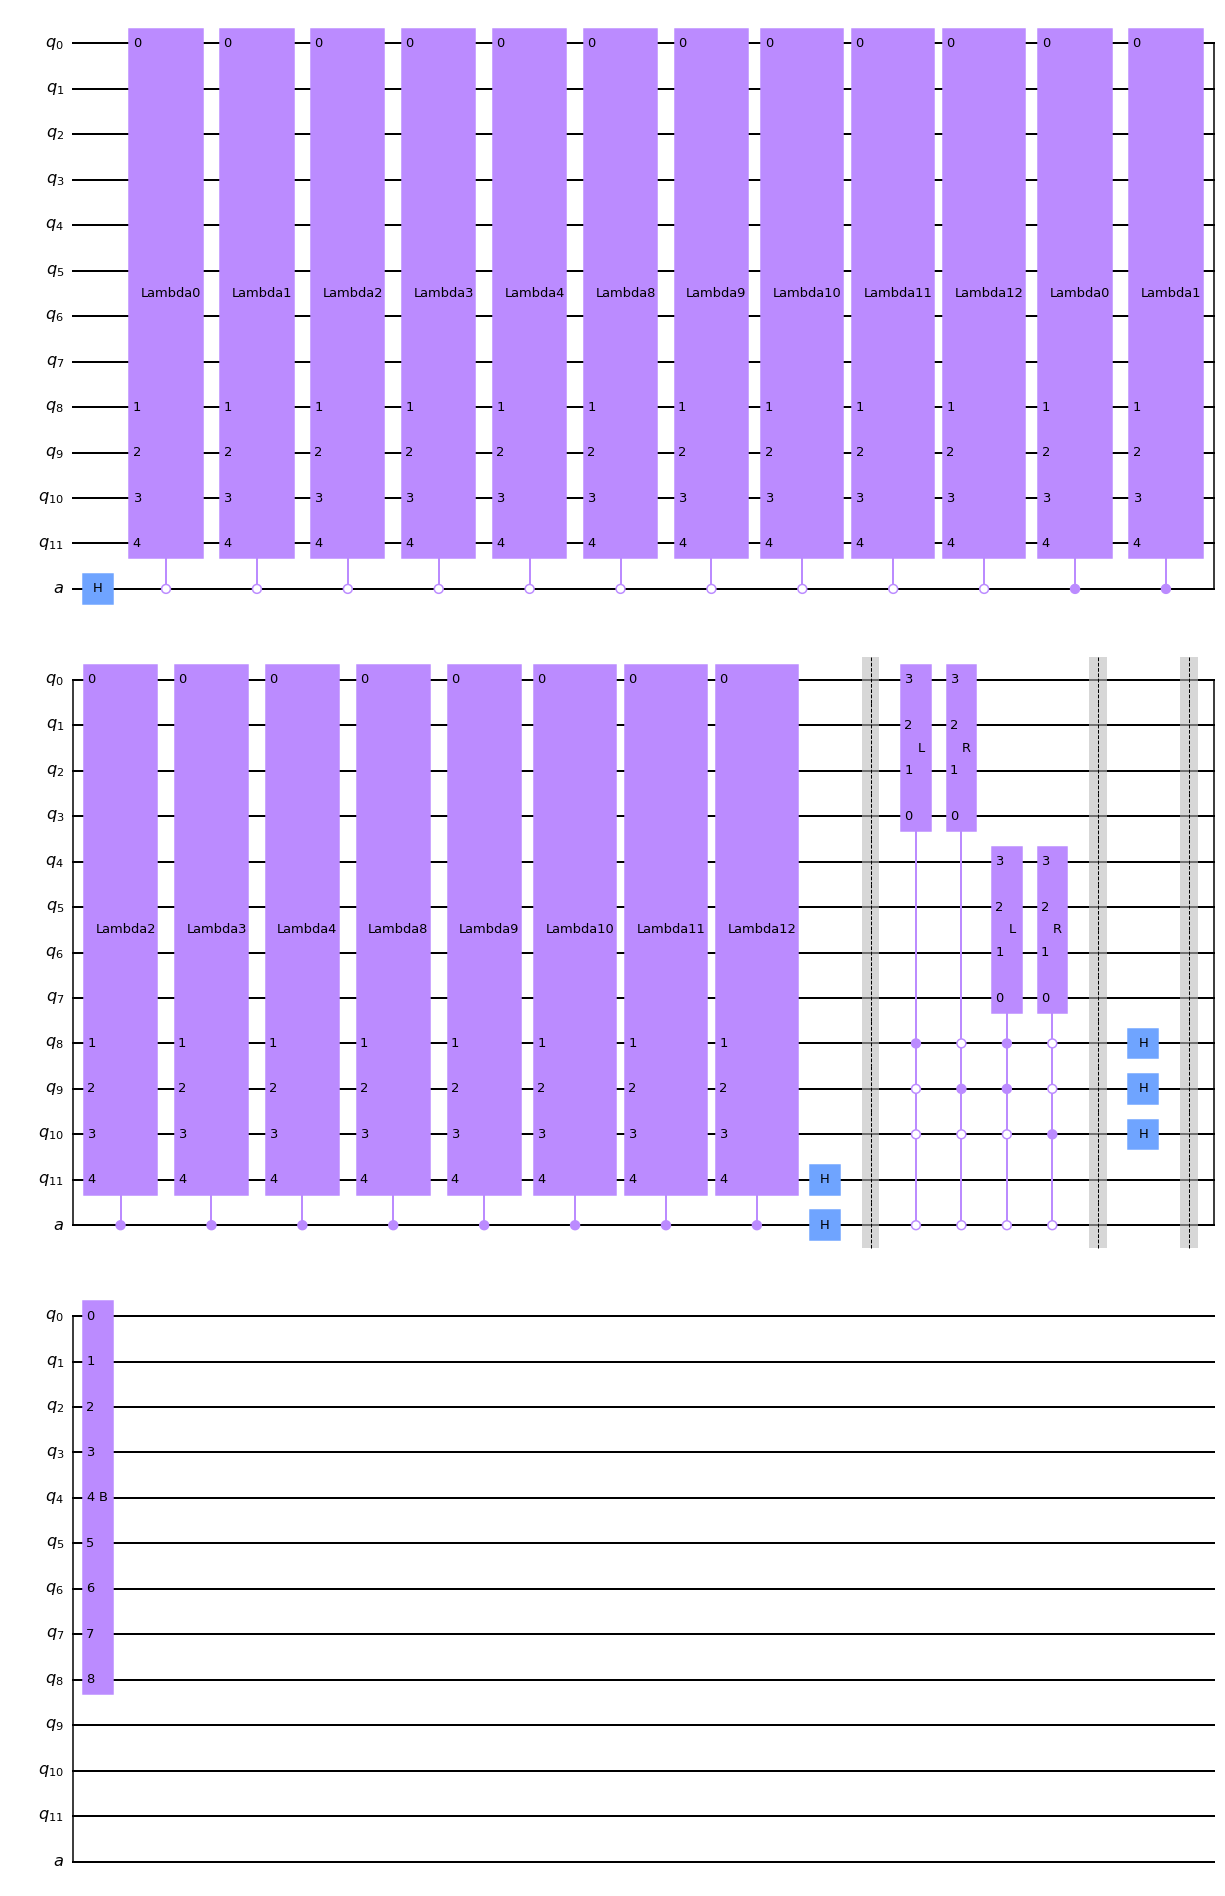

In [41]:
def streamCirc():
    q = QuantumRegister(nlinks+dim*nlat+1,'q')
    a = AncillaRegister(1,'a')

    setup = QuantumCircuit(q)
    setup.add_register(a)

    h1 = qlib.HGate().control(1,ctrl_state = 0)

    cb = [a,0]
    cb.extend([i for i in range(dim*nlat, dim*nlat+nlinks+1)])
#     print([i for i in range(dim*nlat, dim*nlat+nlinks)])
#     setup.append(h1,[11,a])
    setup.h(a)
    for i in range(dirs):
        setup.append(createLambda(i,True).to_gate(label = 'Lambda'+str(i)).control(1,ctrl_state = 0),cb)
    for i in range(8,13):
        setup.append(createLambda(i,True).to_gate(label = 'Lambda'+str(i)).control(1,ctrl_state = 0),cb)
    for i in range(dirs):
        setup.append(createLambda(i,False).to_gate(label = 'Lambda'+str(i)).control(1,ctrl_state = 1),cb)
    for i in range(8,13):
        setup.append(createLambda(i,False).to_gate(label = 'Lambda'+str(i)).control(1,ctrl_state = 1),cb)
#     setup.append(h1,[11,a])
    setup.h(q[11])
    setup.h(a)
    
    setup.barrier()
    L1 = lshift(nlat).to_gate(label = "L").control(nlinks+1,ctrl_state = '0001')
    R1 = rshift(nlat).to_gate(label = "R").control(nlinks+1,ctrl_state = '0010')
    L2 = lshift(nlat).to_gate(label = "L").control(nlinks+1,ctrl_state = '0011')
    R2 = rshift(nlat).to_gate(label = "R").control(nlinks+1,ctrl_state = '0100')
    setup.append(L1,[8,9,10,a[0],3,2,1,0])
    setup.append(R1,[8,9,10,a[0],3,2,1,0])
    setup.append(L2,[8,9,10,a[0],7,6,5,4])
    setup.append(R2,[8,9,10,a[0],7,6,5,4])
    setup.barrier()


#     setup.append(h1,[11,8])
#     setup.append(h1,[11,9])
#     setup.append(h1,[11,10])
    setup.h(8)
    setup.h(9)
    setup.h(10)
    setup.barrier()

    B = QuantumCircuit(QuantumRegister(9))
    B1d, B2d = createADiag()
    B.diagonal(list(np.concatenate((B1d,B2d))), qubit=[0,1,2,3,4,5,6,7,8])
    B = B.to_gate(label='B')

    setup.append(B,[q[0],q[1],q[2],q[3],q[4],q[5],q[6],q[7],q[8]])

#     setup.barrier()
#     h2 = qlib.HGate().control(1,ctrl_state = 1)
#     setup.append(h2,[11,10])
#     setup.append(h2,[11,9])
#     setup.append(h2,[11,8])
#     setup.swap(11,8)
#     setup.h(8)

#     setup.draw()
    return setup
streamCirc().draw()

In [42]:
#calculating derivs and diagonal array
def uv(streamfunc):
    #u = streamfunction_y, v = -streamfunction_x
#     streamfunc = np.reshape(streamfunc,(M,M))
    v = (streamfunc[:,1:]-streamfunc[:,:-1])
    u = streamfunc[1:,:]-streamfunc[:-1,:]
    
    v = np.append(v,np.reshape(v[:,-1],(M,1)),axis=1)
    u = np.append(u,u[-1:],axis=0)
    
    v*=-1
    streamfunc = np.reshape(streamfunc,(M*M))
    return u,v

def collision_f(u_vels, v_vels):
    # for f, weights have to be calculated by advection diffusion eq, but u and v must be calculated
    def coef(link,vel):
        return w[link]*(1+e[link]*vel/cs**2)
    func = np.vectorize(coef)
    
    ret = np.zeros((5,M,M))
    ret[0] = func(0,np.zeros((M,M)))
    ret[1] = func(1,u_vels)
    ret[2] = func(2,u_vels)
    ret[3] = func(3,v_vels)
    ret[4] = func(4,v_vels)
    return ret.flatten()

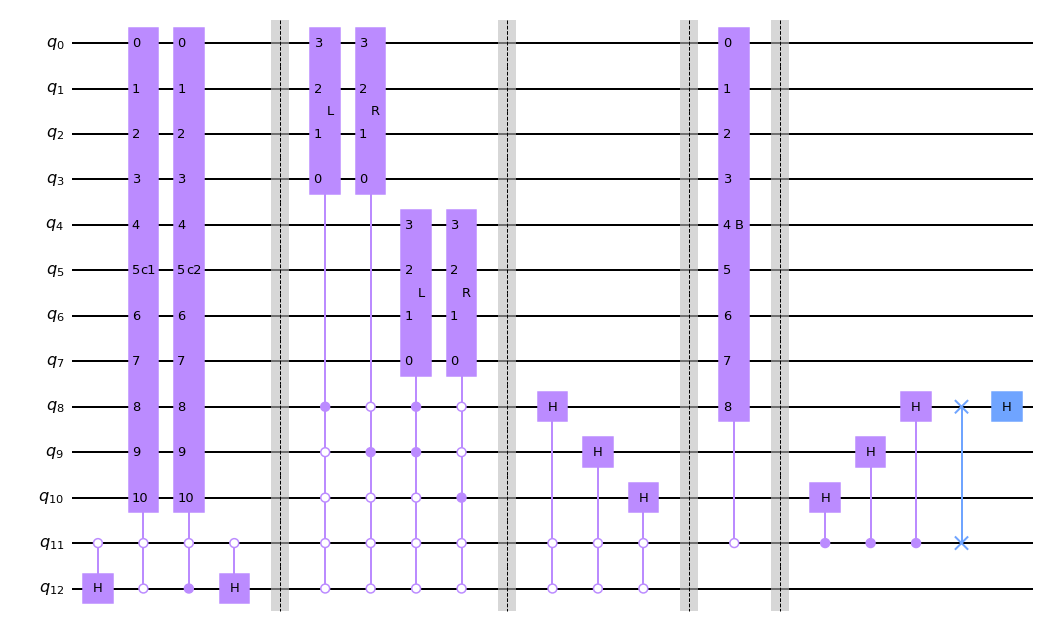

In [43]:
def vortCirc(stream):
    q = QuantumRegister(nlinks+dim*nlat+2,'q')
#     a = AncillaRegister(1,'a')

    setup = QuantumCircuit(q)
#     setup.add_register(a)
    
    h1 = qlib.HGate().control(1,ctrl_state = 0)
    h3 = qlib.HGate().control(2,ctrl_state = '00')
    

#     setup.append(h1,[11,13])
    
    
    
    uvel,vvel = uv(stream)
    A_diag = collision_f(uvel,vvel)
    zeros = np.zeros(M*M)
    A_diag = np.concatenate((A_diag, zeros, zeros, zeros))
    B1_diag = top_half(A_diag)
    B2_diag = bottom_half(A_diag)
    Col = QuantumCircuit(QuantumRegister(12))
    Col.diagonal(list(np.concatenate((B1_diag,B2_diag))),qubit = [0,1,2,3,4,5,6,7,8,9,10,11])
    Col = Col.to_gate(label='B')

    setup.append(h1,[11,12])
    
    Col1 = QuantumCircuit(QuantumRegister(11))
    Col1.diagonal(list(B1_diag),qubit = [0,1,2,3,4,5,6,7,8,9,10])
    Col1 = Col1.to_gate(label='c1')
    
    Col2 = QuantumCircuit(QuantumRegister(11))
    Col2.diagonal(list(B2_diag),qubit = [0,1,2,3,4,5,6,7,8,9,10])
    Col2 = Col2.to_gate(label='c2')
    
    setup.append(Col1.control(2,ctrl_state = '00'),[12,11,0,1,2,3,4,5,6,7,8,9,10])
    setup.append(Col2.control(2,ctrl_state = '01'),[12,11,0,1,2,3,4,5,6,7,8,9,10])

    setup.append(h1,[11,12])

#     setup.append(Col.control(1,ctrl_state = 0),[11,0,1,2,3,4,5,6,7,8,9,10,12])


    setup.barrier()
    L1 = lshift(nlat).to_gate(label = "L").control(nlinks+2,ctrl_state = '00001')
    R1 = rshift(nlat).to_gate(label = "R").control(nlinks+2,ctrl_state = '00010')
    L2 = lshift(nlat).to_gate(label = "L").control(nlinks+2,ctrl_state = '00011')
    R2 = rshift(nlat).to_gate(label = "R").control(nlinks+2,ctrl_state = '00100')
    setup.append(L1,[8,9,10,11,12,3,2,1,0])
    setup.append(R1,[8,9,10,11,12,3,2,1,0])
    setup.append(L2,[8,9,10,11,12,7,6,5,4])
    setup.append(R2,[8,9,10,11,12,7,6,5,4])
    setup.barrier()


    setup.append(h3,[11,12,8])
    setup.append(h3,[11,12,9])
    setup.append(h3,[11,12,10])
    setup.barrier()

    B = QuantumCircuit(QuantumRegister(9))
    B1d, B2d = createADiag()
    B.diagonal(list(np.concatenate((B1d,B2d))), qubit=[0,1,2,3,4,5,6,7,8])
    B = B.to_gate(label='B')

    setup.append(B.control(1,ctrl_state = 0),[11,q[0],q[1],q[2],q[3],q[4],q[5],q[6],q[7],q[8]])

    setup.barrier()
    h2 = qlib.HGate().control(1,ctrl_state = 1)
    setup.append(h2,[11,10])
    setup.append(h2,[11,9])
    setup.append(h2,[11,8])
    setup.swap(11,8)
    setup.h(8)

    setup.draw()
    return setup

vortCirc(streamfunction).draw()

In [44]:
def calcBounds(streamfunction):
    arr = np.zeros((M,M))
    arr[-1] = -2*streamfunction[-2]
    arr[:,0] = -2*streamfunction[:,1]
    arr[:,-1] = -2*streamfunction[:,-2]
    arr[0] = -2*streamfunction[1]-2*U
#     print(arr) 
    return arr#np.zeros((M,M)) # for testing

In [45]:
def Vtimestep(vort, stream):
    bounds = calcBounds(stream)
    zeros = np.zeros((M,M))
    vort = np.concatenate((vort,vort,vort,vort,vort,zeros,zeros,zeros,bounds,zeros,zeros,zeros,zeros,zeros,zeros,zeros)).flatten()
#     print(len(vort))
    vortSV = Statevector(vort).expand([1,0]).evolve(vortCirc(stream))
    vortAr = np.array(vortSV)[:M*M]
    return np.reshape(vortAr,(M,M))

def ttimestep(vort, stream):
    bounds = calcBounds(stream)
    zeros = np.zeros((M,M))
    vort = np.concatenate((vort,vort,vort,vort,vort,zeros,zeros,zeros,bounds,zeros,zeros,zeros,zeros,zeros,zeros,zeros)).flatten()
    vortSV = Statevector(vort).expand([1,0]).evolve(vortCirc(stream))
    vortAr = np.array(vortSV)
    return vortAr

def Stimestep(stream, source):
#     source*=-1
    zeros = np.zeros((M,M))
    stream = np.concatenate((stream,stream,stream,stream,stream,zeros,zeros,zeros,source,source,source,source,source,zeros,zeros,zeros)).flatten()
    streamSV = Statevector(stream).expand([1,0]).evolve(streamCirc())
    streamAr = np.array(streamSV)[:M*M]
    return np.reshape(streamAr,(M,M))

In [46]:
allstreams = []
allvorts = []
# steps = 200
streamfunction = np.zeros((M,M))
vorticity = np.zeros((M,M))
allstreams.append(streamfunction)
allvorts.append(vorticity)

In [47]:
steps = 91
for i in range(steps):
    streamfunction, vorticity = allstreams[-1], allvorts[-1]
    x = Stimestep(streamfunction,vorticity)
    y = Vtimestep(vorticity, streamfunction)
    allstreams.append(np.real(x)*2**(4/2))
    allvorts.append(np.real(y)*2**(4/2))
#     if i%2 == 0:
#         graphC(allstreams[i],i,5)

In [48]:
print(len(allstreams))

92


In [49]:
def graphC(st,it,levels):
    fig, ax = plt.subplots()
    CS = ax.contour(np.arange(M), np.arange(M), st, levels = levels)
    ax.clabel(CS, inline=True, fontsize=10)
    ax.set_title('t='+str(it))
    ax.set_aspect('equal', adjustable='box')

/var/folders/jp/s01ry41n1ksb327qbnx4y_bh0000gn/T/ipykernel_48373/521276314.py:3: UserWarning: No contour levels were found within the data range.
  CS = ax.contour(np.arange(M), np.arange(M), st, levels = levels)


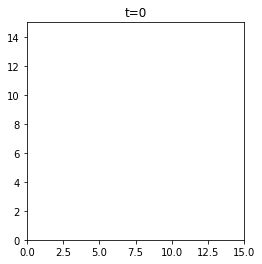

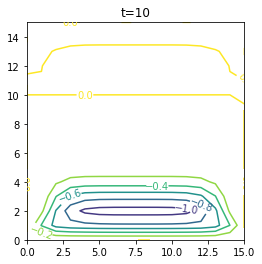

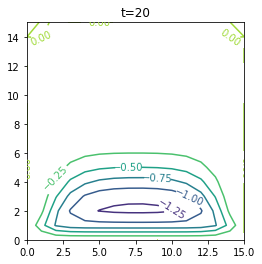

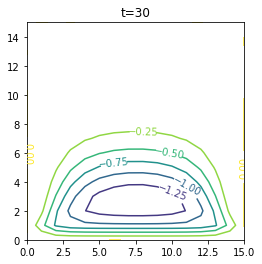

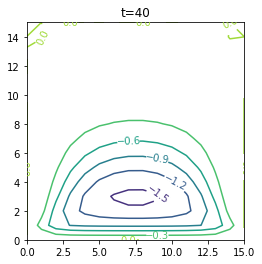

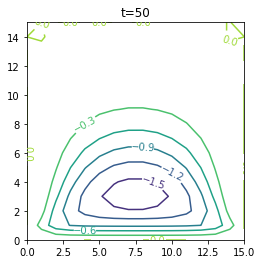

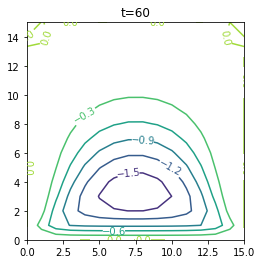

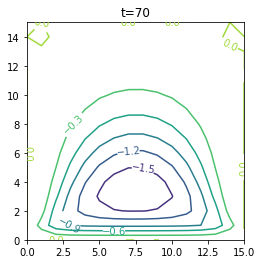

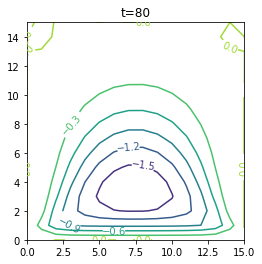

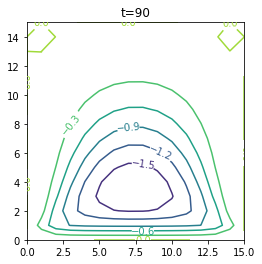

In [50]:
for i in range(0,91,10):
    graphC(allstreams[i],i,5)

/var/folders/jp/s01ry41n1ksb327qbnx4y_bh0000gn/T/ipykernel_19856/521276314.py:3: UserWarning: No contour levels were found within the data range.
  CS = ax.contour(np.arange(M), np.arange(M), st, levels = levels)


IndexError: list index out of range

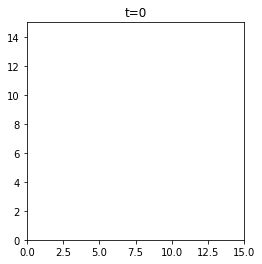

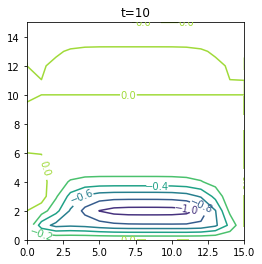

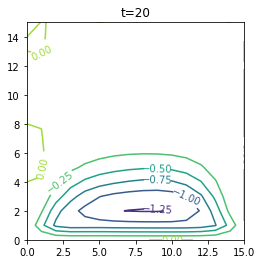

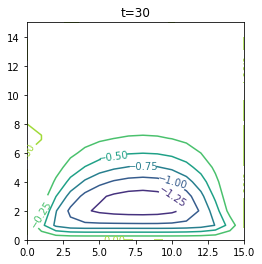

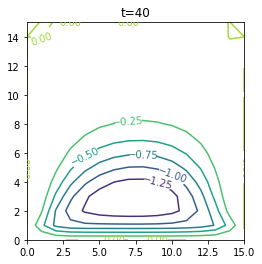

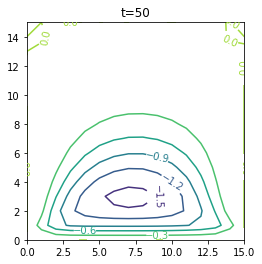

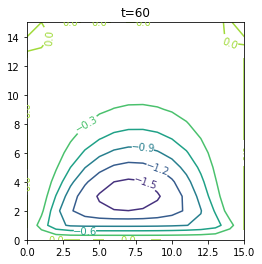

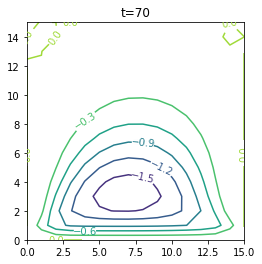

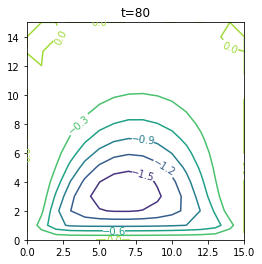

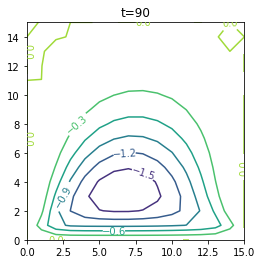

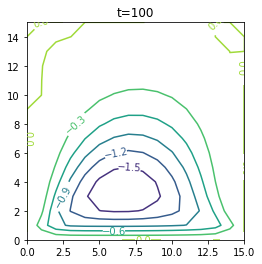

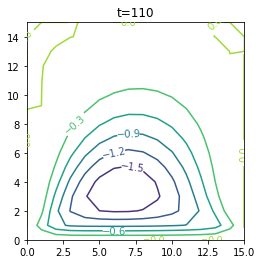

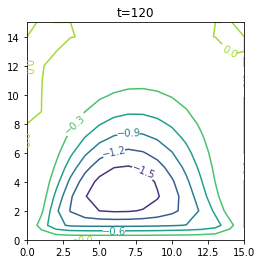

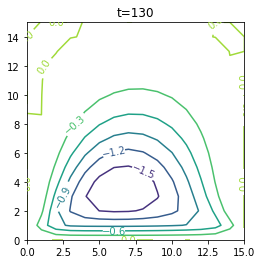

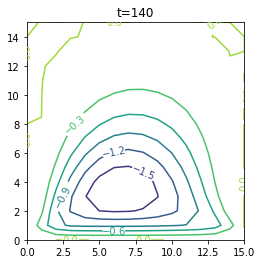

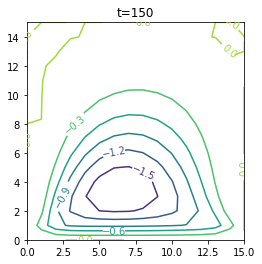

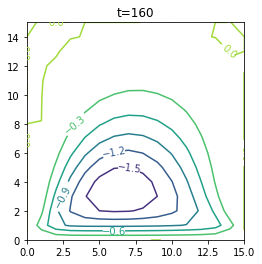

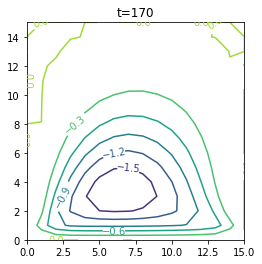

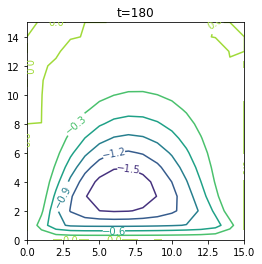

In [43]:
for i in range(0,201,10):
    graphC(allstreams[i],i,5)